# Hierarchical pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the values of L, $\theta$, and $a_g$ for each individual pendulum using a hierarchical setup.

In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
from jax import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
import arviz as az
import corner

## Hierarchical setup first

In [2]:
# p(a,phi,theta,L|x)
# a is local to a planet
# phi is akin to redshift for the lenses (observable?)
# G is global, target of inference
# a = G * phi ; G constant
# phi = M/r**2
# phi[0], phi[1], phi[2].. phi[8]

def pendulum_pos(N_planets, N_pendulums, error, pos=None):
    
    # specify the sampling distribution using the model parameters
    mu = numpyro.sample('mu', dist.Uniform(1,10))
    tau2 = numpyro.sample('tau2', dist.Uniform(1,10))
    
    # plate means assuming data are independent
    with numpyro.plate('Planets', N_planets):
        a = numpyro.sample('a_g', dist.Normal(mu, tau2))
            
        with numpyro.plate('Pendulums', N_pendulums):
            # these are the priors for parameters we are fitting
            theta = numpyro.sample('theta', dist.Uniform(0,jnp.pi/2))
            L = numpyro.sample('Length', dist.Uniform(0,10))

            # transformed parameters using the deterministic function
            # if necessary
            modelx = numpyro.deterministic('modelx', L * jnp.sin(theta * jnp.cos(jnp.sqrt(a / L)) * 1))

            numpyro.sample('obs', dist.Normal(modelx, error), obs=pos)



In [3]:
# There's a true data point
L_true = 5
theta_true = jnp.pi/4
a_true = 10
pos_true = L_true * jnp.sin(theta_true * jnp.cos(jnp.sqrt(a_true / L_true)) * 1)

In [4]:
# Make the data
import pandas as pd

# Sample data for the DataFrame
data = {
    'length': [10, 15, 20, 12],
    'theta': [jnp.pi/4, jnp.pi/4, jnp.pi/4, jnp.pi/4],
    #'a_g': [0.5, 0.8, 1.2, 0.9],
    'planet_id': ['Earth', 'Earth', 'Mars', 'Mars'],
    'phi': [1, 1, 0.5, 0.5],
    'G': [10, 10, 10, 10],
    'pos_err': [0.1, 0.1, 0.1, 0.1],
}

# Create the DataFrame
df = pd.DataFrame(data)
print(df)

   length     theta planet_id  phi   G  pos_err
0      10  0.785398     Earth  1.0  10      0.1
1      15  0.785398     Earth  1.0  10      0.1
2      20  0.785398      Mars  0.5  10      0.1
3      12  0.785398      Mars  0.5  10      0.1


In [5]:
# Now introduce noise and solve for position
df['a_g'] = df['G'] * df['phi']
df['pos'] = df['length'] * np.sin(df['theta'] * np.cos(np.sqrt(df['a_g'] / df['length'])) * 1)

df

,length,theta,planet_id,phi,G,pos_err,a_g,pos
0,10,0.785398,Earth,1.0,10,0.1,10.0,4.117307
1,15,0.785398,Earth,1.0,10,0.1,10.0,7.684023
2,20,0.785398,Mars,0.5,10,0.1,5.0,12.719198
3,12,0.785398,Mars,0.5,10,0.1,5.0,7.044276


In [15]:
def pendulum_model(planet_code, error, obs_pos=None):
    μ_phi = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_phi = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    G = 10
    
    #a_g = numpyro.sample("a_g", dist.HalfNormal(3.0))

    n_planets = len(np.unique(planet_code))

    with numpyro.plate("planet_i", n_planets):
        a_g = numpyro.sample("a_g", dist.Normal(μ_phi, σ_phi))
        #β = numpyro.sample("β", dist.Normal(μ_β, σ_β))
        
        L = numpyro.sample("L", dist.HalfNormal(5.0))
        theta = numpyro.sample("theta", dist.HalfNormal(jnp.pi/4))

    #σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    #FVC_est = α[planet_code] + β[planet_code] * Weeks
    pos = L[planet_code] * jnp.sin(theta[planet_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L[planet_code])) * 1)

    # length of the dataframe (for all ind pendulums)
    with numpyro.plate("data", len(planet_code)):
        numpyro.sample("obs", dist.Normal(pos, error), obs=obs_pos)

In [16]:
from sklearn.preprocessing import LabelEncoder

planet_encoder = LabelEncoder()
df["planet_code"] = planet_encoder.fit_transform(df["planet_id"].values)

obs_pos = df["pos"].values
planet_code = df["planet_code"].values
error = df["pos_err"].values
print(planet_code)

[0 0 1 1]


In [17]:


nuts_kernel = NUTS(pendulum_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, planet_code, error, obs_pos = obs_pos)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2283.62it/s, 132 steps of size 2.19e-02. acc. prob=0.88]


In [20]:
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],9.613,2.572,5.807,14.027,0.172,0.122,200.0,168.0,NaN
L[1],11.068,1.330,9.663,13.573,0.114,0.082,178.0,180.0,NaN
a_g[0],6.141,5.214,0.002,15.898,0.377,0.267,157.0,256.0,NaN
a_g[1],400.537,67.906,297.137,529.026,5.230,3.778,195.0,204.0,NaN
theta[0],1.101,0.410,0.432,1.816,0.030,0.021,166.0,151.0,NaN
theta[1],1.417,0.341,0.766,2.022,0.025,0.018,169.0,176.0,NaN
μ_α,193.036,122.843,-35.945,431.530,5.830,4.361,443.0,482.0,NaN
σ_α,170.878,53.254,92.673,275.689,3.364,2.381,244.0,407.0,NaN


In [ ]:
# This is the overall sampler
corner.corner(inf_data);

In [ ]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(df, compact=True, figsize=(15, 25));

In [ ]:


error = 0.1
# Generate samples from the prior...
prior_pred = numpyro.infer.Predictive(pendulum_pos, num_samples=50)(
    jax.random.PRNGKey(11), 10, 1, error
)

# ...and plot them:
label = "prior samples"
print(jnp.shape(prior_pred["obs"]))
#print(prior_pred["obs"])
for n in range(len(prior_pred["obs"])):
    plt.hist(
        prior_pred["obs"][n],
        50,
        range=(-1, 10),
        histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5,
        label=label,
    )
    label = None

plt.hist(pos_true, 120, histtype="step", color="C0", label="data")
plt.legend()
plt.xlabel("pendulum position")
plt.ylabel("count");
#plt.xlim(0.2, 3);

<div class="alert alert-danger">
I'm a little perplexed about how to organize the data. What if you have a double hierarchy? In DFM's blog, it looks like there's one collection of data. This data is not used to train the model, but the error dataset is an important component to train the model.
    
But the observed data points do come into play when running inference. You run it all at once for the entire collection of data. But shouldn't the hierarchy matter in how the data is structured? I feel like DFM is only doing one lyaer of hierarchy because the group parameters are inferred for all individual star parallaxes at once.
</div>

[[2. 2. 2. 2.]
 [2. 2. 2. 2.]] (2, 4)


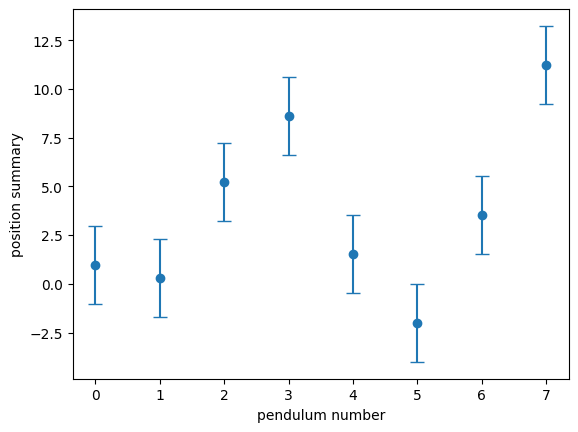

In [5]:
# Construct the data
# four pendulums on each planet
x = [[0,1,2,3],[4,5,6,7]]
#x = [0,1,2,3,4,5,6,7]
N_pendulums = 8
N_planets = 2

# Generate the data
true_Ls = [[6, 8, 10, 12],
           [6, 8, 10, 12]]
true_thetas = [[0, jnp.pi/8, jnp.pi/4, 3*jnp.pi/4],
               [0, jnp.pi/8, jnp.pi/4, 3*jnp.pi/4]]
true_as = [[8, 8, 8, 8],
           [12, 12, 12, 12]]
true_params = np.array([true_Ls, true_thetas, true_as])

# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)
yerr = 2 * np.ones(np.shape(true_Ls))

#y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))
print(yerr,np.shape(yerr))
y = true_params[0] * jnp.sin(true_params[1] * jnp.cos(jnp.sqrt(true_params[2] / true_params[0]))) + yerr * np.random.randn(2,4)
#L * jnp.sin(theta * jnp.cos(jnp.sqrt(a / L)) * 1)

#y = np.array([8.0, 8.0, 3.0, 7.0, 1.0, 1.0, 18.0, 12.0])

#sigma = 

plt.errorbar(np.reshape(x,8), np.reshape(y,8), yerr = np.reshape(yerr,8), linestyle = 'None', capsize = 5)
plt.scatter(np.reshape(x,8), np.reshape(y,8))
plt.ylabel('position summary')
plt.xlabel('pendulum number');

In [6]:
# First check what the prior predictive distribution looks like
# Before running the MCMC
prior_pred = numpyro.infer.Predictive(pendulum_pos, num_samples = 500)(
    random.PRNGKey(1), N_planets, N_pendulums, yerr
)
print(prior_pred['obs'], np.shape(prior_pred['obs']))

# ...and plot them:
label = "prior samples"
for n in range(len(prior_pred["obs"])):
    plt.hist(
        prior_pred['obs'][n],
        histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5)

#plt.hist(data["parallax"], 120, histtype="step", color="C0", label="data")
plt.legend()
plt.xlabel("position")
plt.ylabel("count");

ValueError: Incompatible shapes for broadcasting: shapes=[(), (8, 2), (2, 4)]

In [14]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(pendulum_pos),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(random.PRNGKey(0), N_planets, N_pendulums, yerr, y=y)

/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_77307/2302782971.py:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = numpyro.infer.MCMC(


ValueError: Incompatible shapes for broadcasting: shapes=[(), (8, 2), (2, 4)]

In [39]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],4.459,2.646,0.062,8.898,0.041,0.030,3841.0,2394.0,1.0
L[1],4.071,2.645,0.000,8.637,0.041,0.031,3865.0,2394.0,1.0
L[2],7.161,2.045,3.480,9.999,0.033,0.024,3747.0,2168.0,1.0
L[3],8.425,1.263,6.105,9.998,0.018,0.013,4347.0,2111.0,1.0
L[4],4.743,2.781,0.010,9.211,0.039,0.028,4697.0,2693.0,1.0
L[5],3.320,2.312,0.004,7.759,0.036,0.029,4111.0,2370.0,1.0
L[6],6.090,2.486,1.441,9.999,0.038,0.027,4556.0,2166.0,1.0
L[7],8.982,0.878,7.381,10.000,0.011,0.008,4163.0,2098.0,1.0
a_g[0],7.878,4.270,1.107,14.960,0.056,0.042,5415.0,2431.0,1.0
a_g[1],8.184,4.166,1.344,14.983,0.054,0.041,5836.0,3131.0,1.0


In [40]:
# This is the overall sampler
corner.corner(inf_data);

In [41]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      L[0]      4.46      2.65      4.37      0.01      8.22   4160.53      1.00
      L[1]      4.07      2.64      3.79      0.00      7.90   4121.58      1.00
      L[2]      7.16      2.05      7.50      4.36     10.00   3684.92      1.00
      L[3]      8.43      1.26      8.71      6.68     10.00   4873.27      1.00
      L[4]      4.74      2.78      4.70      0.02      8.69   4817.82      1.00
      L[5]      3.32      2.31      2.88      0.01      6.73   4057.38      1.00
      L[6]      6.09      2.49      6.40      2.42     10.00   4232.62      1.00
      L[7]      8.98      0.88      9.20      7.77     10.00   5964.78      1.00
    a_g[0]      7.88      4.27      8.04      1.90     14.99   5790.85      1.00
    a_g[1]      8.18      4.17      8.45      2.10     14.92   5838.94      1.00
    a_g[2]      5.86      3.92      5.37      0.02     11.66   4922.13      1.00
    a_g[3]      4.16      3

In [42]:
print(sampler.get_samples()['a_g'])

[[14.068749    9.344424    0.9644659  ... 13.886435    1.6171364
   1.5710981 ]
 [13.566829    5.7804737   0.5558535  ... 11.336882    3.443366
   2.6744258 ]
 [ 0.8468198  11.252968    3.4382198  ...  6.877056    7.6531067
   4.2833233 ]
 ...
 [ 4.6356106  11.3090515   0.39835787 ...  4.805338   14.310468
   0.7477141 ]
 [ 8.455225   14.108084   11.445648   ... 12.279903   14.708537
   3.8847833 ]
 [ 8.294214    6.54883     7.094577   ...  7.8261395   7.72105
   3.372794  ]]


[Array(0.74439514, dtype=float32), Array(0.5215956, dtype=float32), Array(3.9255164, dtype=float32), Array(6.531228, dtype=float32), Array(1.0387791, dtype=float32), Array(-0.09436026, dtype=float32), Array(2.3962178, dtype=float32), Array(7.7954936, dtype=float32)]


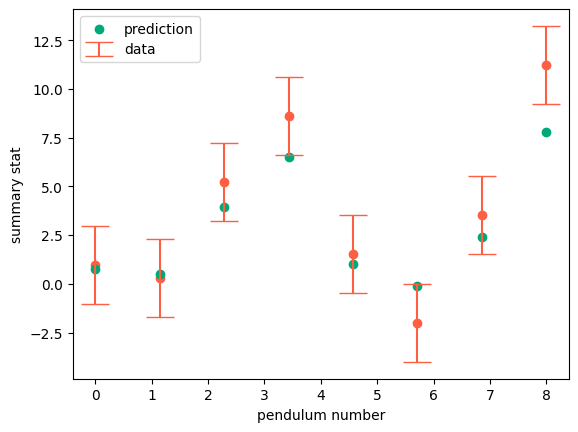

In [46]:
N = N_pendulums
estimates = [np.mean(sampler.get_samples()['pos'][:,i]) for i in range(N_pendulums)]
print(estimates)
plt.clf()
plt.scatter(np.linspace(0,N,N), y, color = '#FE5E41')
plt.errorbar(np.linspace(0,N,N), y, yerr = yerr, linestyle='None',
             capsize = 10, color = '#FE5E41', label = 'data')
#estimates = [np.mean(np.array(mcmc.get_samples()['theta'][x])) for x in np.linspace(0,J,J)]
plt.scatter(np.linspace(0,N,N), estimates, color='#00A878', label = 'prediction')
'''
plt.axhline(y = np.mean(sampler.get_samples()['mu']), color = '#F3C178',
            label = 'overall mean')
plt.axhline(y = np.mean(sampler.get_samples()['mu']) - np.std(mcmc.get_samples()['mu']),
            linestyle='--', color = '#F3C178')
plt.axhline(y = np.mean(sampler.get_samples()['mu']) + np.std(mcmc.get_samples()['mu']),
            linestyle='--', color = '#F3C178')
'''
plt.ylabel('summary stat')
plt.xlabel('pendulum number')
plt.legend()

### Results
Essentially, this is a non-hierarchical model, so the model is not learning from the groups. Instead, it is treating every pendulum individually. This means it does a much poorer job of predicting the position and of predicting the acceleration due to gravity.

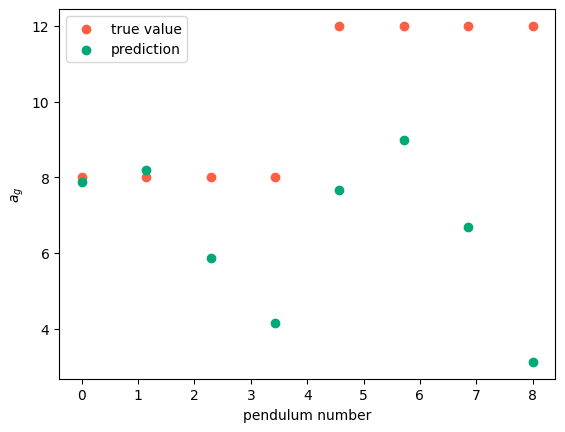

In [49]:
N = N_pendulums
estimates = [np.mean(sampler.get_samples()['a_g'][:,i]) for i in range(N_pendulums)]
plt.clf()
plt.scatter(np.linspace(0,N,N), true_params[2], color = '#FE5E41', label = 'true value')
plt.scatter(np.linspace(0,N,N), estimates, color='#00A878', label = 'prediction')
'''
plt.axhline(y = np.mean(sampler.get_samples()['mu']), color = '#F3C178',
            label = 'overall mean')
plt.axhline(y = np.mean(sampler.get_samples()['mu']) - np.std(mcmc.get_samples()['mu']),
            linestyle='--', color = '#F3C178')
plt.axhline(y = np.mean(sampler.get_samples()['mu']) + np.std(mcmc.get_samples()['mu']),
            linestyle='--', color = '#F3C178')
'''
plt.ylabel('$a_g$')
plt.xlabel('pendulum number')
plt.legend()